# Preamble

## Imports

In [104]:
##ALL OF THE IMPORTS AND SUCH

import os
from concurrent.futures import ProcessPoolExecutor, as_completed


from LightPipes import *
from LightPipes import Field

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import math
import cmath
from numpy import genfromtxt
import colorcet as cc
import random
import aotools
import itertools
from tqdm import tqdm as progress
import random

import numpy as np
from numpy.linalg import eig,eigh
import scipy as sp

import pylab as pl

import numpy as np

# Parallelization Utilities
from parallel_utils import init_worker, propagateSinglePixel_Optimized

# General Functions
from functions import ell, MUBphases, MixManyBeams, OAM, ANG, ArbMUB, Fqubit

# Generating beam plots
from functions import plotBeam, plotBeamTransparent

# Overlap integrals and crosstalk
from functions import overlapInt, normTomography, crosstalkVecs, crosstalk, tomography, plotCrosstalk, beamsError

# Propagation
from functions import propChannel, propChannelSteps

# Parellelization of propagation of all pixels
from functions import propagateSinglePixel, parallelpropagatePixels

# Colours
from colours import colours
pmap, _, customColoursBGY, _ = colours()

#plt.style.use('dark_background')
plt.close('all')

## Crap for making videos - NOT IMPORTANT KEEP COMMENTED OUT but maybe we can put it in the functions

In [105]:
# plt.show(plotBeamTransparent(Fqubit(F,w,4,0,2,0)))

In [106]:
# N=128
# w=8.1*cm

# F=Begin(size=40*cm,labda=633*nm,N=N)
# #beamlist=[OAM(F,w,j) for j in ell(8)] + [ANG(F,w,8,j) for j in range(8)]
# d=4
# k,m=3,0

# beamlist=[Fqubit(F,w,d,j,k,m) for j in [0,1,2] for k in range(j+1,d) for m in range(d)]

# for i,phase in enumerate(np.arange(0,2*np.pi,np.pi/120)):
#     fig=plotBeamTransparent([SubPhase(beam,Phase(beam)+phase) for beam in beamlist],dpi=N,rows=2)
#     plt.savefig(f"figs/fqb/output{i:03d}.png",pad_inches=0,dpi=N)
#     plt.close(fig)


In [107]:
# import subprocess
# import os

# def create_transparent_webm(image_folder, output_name="beam_movie.webm", fps=120):
#     # Ensure filenames are sorted (e.g., output0.png, output1.png...)
#     # We use a text file list for FFmpeg to handle non-sequential naming
#     input_list = "images.txt"
#     filenames = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    
#     with open(input_list, "w") as f:
#         for fname in filenames:
#             f.write(f"file '{os.path.join(image_folder, fname)}'\n")

#     # FFmpeg command for VP9 WebM with Alpha:
#     # -f concat: use the text file list
#     # -pix_fmt yuva420p: The 'a' stands for Alpha (transparency support)
#     # -auto-alt-ref 0: Required for transparency in some VP9 versions
#     cmd = [
#         'ffmpeg', '-y', 
#         '-r', str(fps), 
#         '-f', 'concat', '-safe', '0', '-i', input_list,
#         '-c:v', 'libvpx-vp9', 
#         '-pix_fmt', 'yuva420p', 
#         '-auto-alt-ref', '0', 
#         output_name
#     ]

#     try:
#         subprocess.run(cmd, check=True)
#         print(f"Successfully saved transparent video: {output_name}")
#     except subprocess.CalledProcessError as e:
#         print(f"Error running FFmpeg: {e}")
#     finally:
#         if os.path.exists(input_list):
#             os.remove(input_list)


In [108]:
# create_transparent_webm('figs/fqb', 'vids/fqb_02s.webm', fps=120)

## Functions

# Channel Creation and Propagation

## Create Channel and Prop OAM

In [109]:
#Simulation Parameters
size = 40*cm
N=64

lensSize=size/4 # Radius

#Beam Parameters
wavelength = 633*nm
w0=6.67/1.5*cm # Radius

#Propagataion Params
z=5000*m
numberOfPhaseScreens=3

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}

TurbStrength = 'MidTurb'

r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
# Turbulence=2
# r0=size/Turbulence

phase_screen_seed=48

abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

#Default Beam
F=Begin(size,wavelength,N)

100%|██████████| 4/4 [00:00<00:00, 142.92it/s]


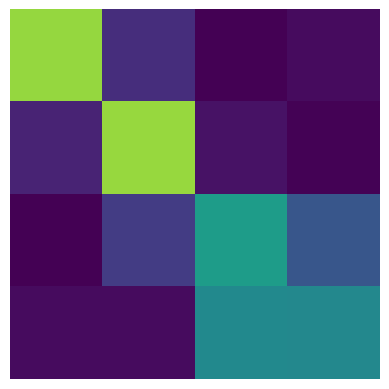

Error rate of 0.3236942057408939


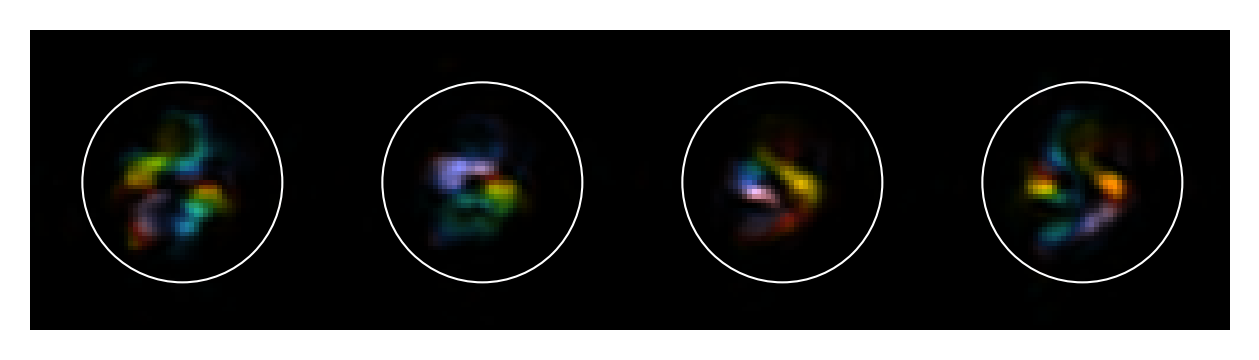

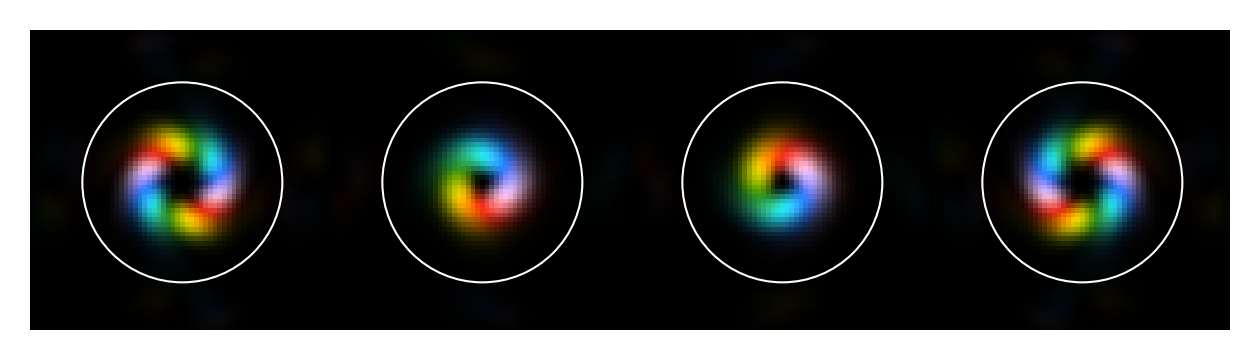

In [110]:
beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(ell(4))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs) for i in progress(ell(4))]


plt.show(plotCrosstalk(crosstalk(beams,errorBeams)))
print(f'Error rate of {beamsError(beams,errorBeams)}')

plt.show(plotBeam(errorBeams,rows=1,aperature=size/3))
plt.show(plotBeam(beams,rows=1,aperature=size/3))

## Propagate a Singel Pixel with No Turbulence

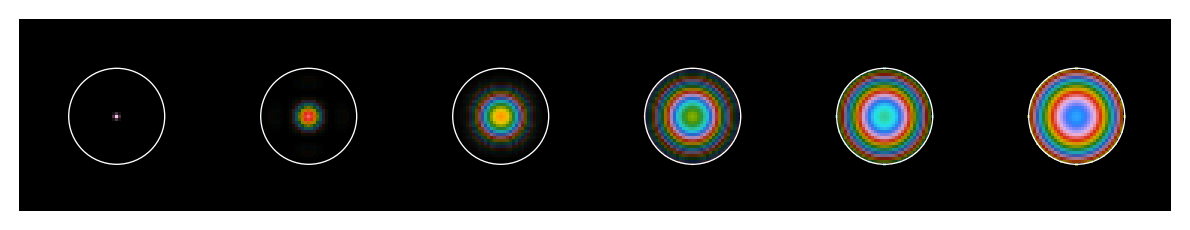

In [111]:
intens = np.zeros((N, N))
intens[N//2][N//2] = 1

#FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
#FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
F2 = [CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(F, intens),np.zeros((N,N))),R=lensSize), dist),R=lensSize) for dist in [1,1000,2000,3000,4000,5000]]

plt.show(plotBeam(F2,aperature=lensSize,dpi=3*N))


## Propagate all Pixels

In [112]:
def parallelpropagatePixels(FieldIn, N, z, lensSize, abbs):
    FieldsOut = []
    endFields_data = []
    
    # Determine worker count (Platform Agnostic)
    max_workers = max(1, (os.cpu_count() or 4) - 2)
    print(f"Using {max_workers} workers to propagate beams...")

    # Create task list of coordinate indices
    tasks = [(j, i) for j in range(N) for i in range(N)]

    # Use raw data for better serialization performance on Windows
    field_raw = FieldIn.field
    size = FieldIn.siz
    wavelength = FieldIn.lam
    
    # ProcessPoolExecutor with initializer for shared data efficiency
    with ProcessPoolExecutor(
        max_workers=max_workers,
        initializer=init_worker,
        initargs=(field_raw, size, wavelength, N, z, lensSize, abbs)
    ) as executor:
        
        future_to_task = {
            executor.submit(propagateSinglePixel_Optimized, j, i): (j, i) 
            for j, i in tasks
        }
        
        results_iterator = progress(
            as_completed(future_to_task), 
            total=len(tasks), 
            desc="Propagating individual Pixels"
        )
        
        for future in results_iterator:
            try:
                FieldOut, endField_data = future.result()
                FieldsOut.append(FieldOut)
                endFields_data.append(endField_data)
            except Exception as exc:
                j, i = future_to_task[future]
                print(f'\n(j={j}, i={i}) generated an exception: {exc}')
                
    return FieldsOut, np.array(endFields_data)

if __name__ == "__main__":
    FieldsOut, endFields = parallelpropagatePixels(F, N, z, lensSize, abbs)
    print(f"Successfully processed {len(endFields)} pixels.")

Using 10 workers to propagate beams...


Propagating individual Pixels: 100%|██████████| 4096/4096 [00:10<00:00, 393.11it/s]


Successfully processed 4096 pixels.


## Infinite Phase Screen

In [113]:
from aotools.turbulence.infinitephasescreen import PhaseScreenKolmogorov
# Note that i set L0=75, if you try L0=100 you get some error at least for N=64. For N=64 we need L0<90 from my testing
inf_ps = PhaseScreenKolmogorov(N, size/N, r0, 75,random_seed=phase_screen_seed)
inf_ps1 = inf_ps.scrn
inf_ps2 = PhaseScreenKolmogorov.get_new_row(inf_ps)

for i in range(0,int(N/1.5)):
    inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)

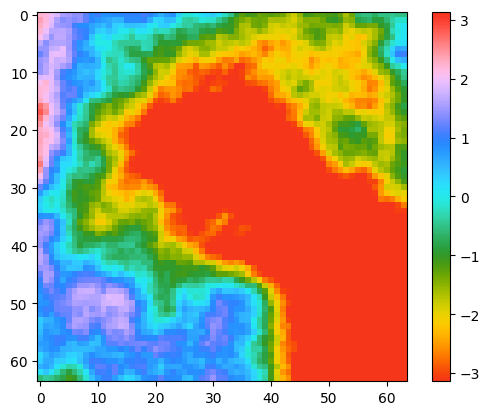

In [114]:
plt.imshow(inf_ps1, cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

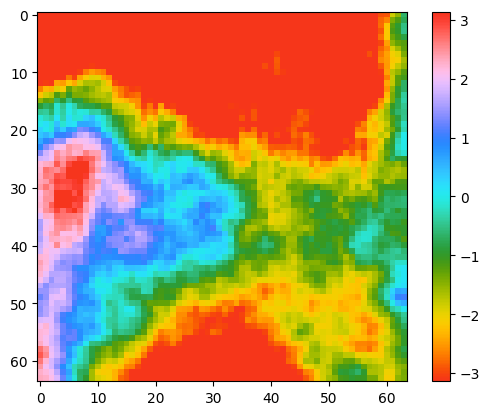

In [115]:
plt.imshow(inf_ps3, cmap=pmap, vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [117]:
# PSUEDO CODE for adding phase screens incrementally and propagating a beam through them

# beam=OAM(F,w0+w0/2,0)
# plt.show(plotBeam(beam))

# for i in range(0,int(N/1.5)):

#     inf_ps3 = PhaseScreenKolmogorov.add_row(inf_ps)
    
#     plt.savefig(plotBeam(propChannel(beam,z,abbs)))

# Calculate EigenModes

## Calculate eigenvalues and eigenvectors

In [118]:
transferMatrix=endFields

transferMatrixT=endFields.T

transferMatrixH=endFields.T.conj()

transferMatrixHermitian=transferMatrixH@transferMatrix

eigVals,eigVecs=np.linalg.eig(transferMatrixT)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [119]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

## Plot Eigenvalues

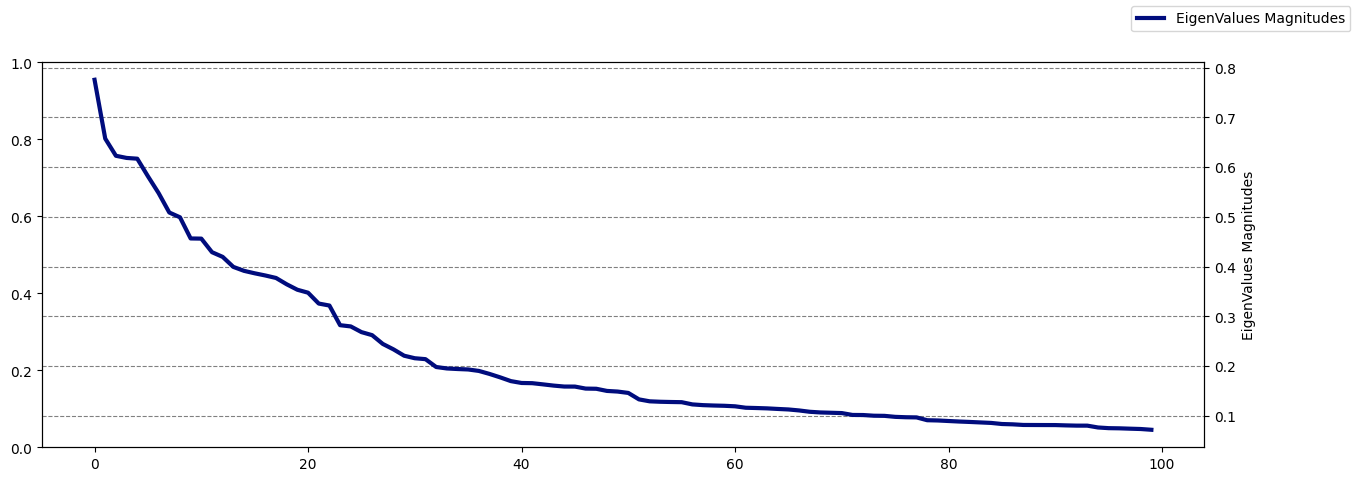

In [120]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:100],eigMags[:100],label='EigenValues Magnitudes',color=customColoursBGY[0],linewidth=3)

fig.legend()
plt.show()

## Create Optical Modes

In [121]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams=[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

eigenBeamPropagated=[propChannel(beam,z,abbs) for beam in progress(eigenBeams)]


100%|██████████| 100/100 [00:00<00:00, 264.20it/s]


### Normalize phase for plotting

In [122]:
############################
####
####
#### Need to normalize the phase on the propagated eigenmode to be able 
####    to display them next to one another and have consistent phase profiles.
####
############################

In [123]:
# Loop through eigenbeams and find position with max intensity and then find the phase there. Then find the difference in phase in the
# same position after propagating and subtract the entire array after propagating by this phase difference

for i, eigenBeam in enumerate(eigenBeams):
    intensity = Intensity(eigenBeam,1)
    max_pos = np.unravel_index(intensity.argmax(), intensity.shape)
    phase_diff = np.mod(Phase(eigenBeamPropagated[i]), 2*np.pi)[max_pos] - np.mod(Phase(eigenBeam), 2*np.pi)[max_pos]
    eigenBeamPropagated[i].field *= np.exp(1j * (-phase_diff)) # Subtract phase difference

## Plot Optical Modes

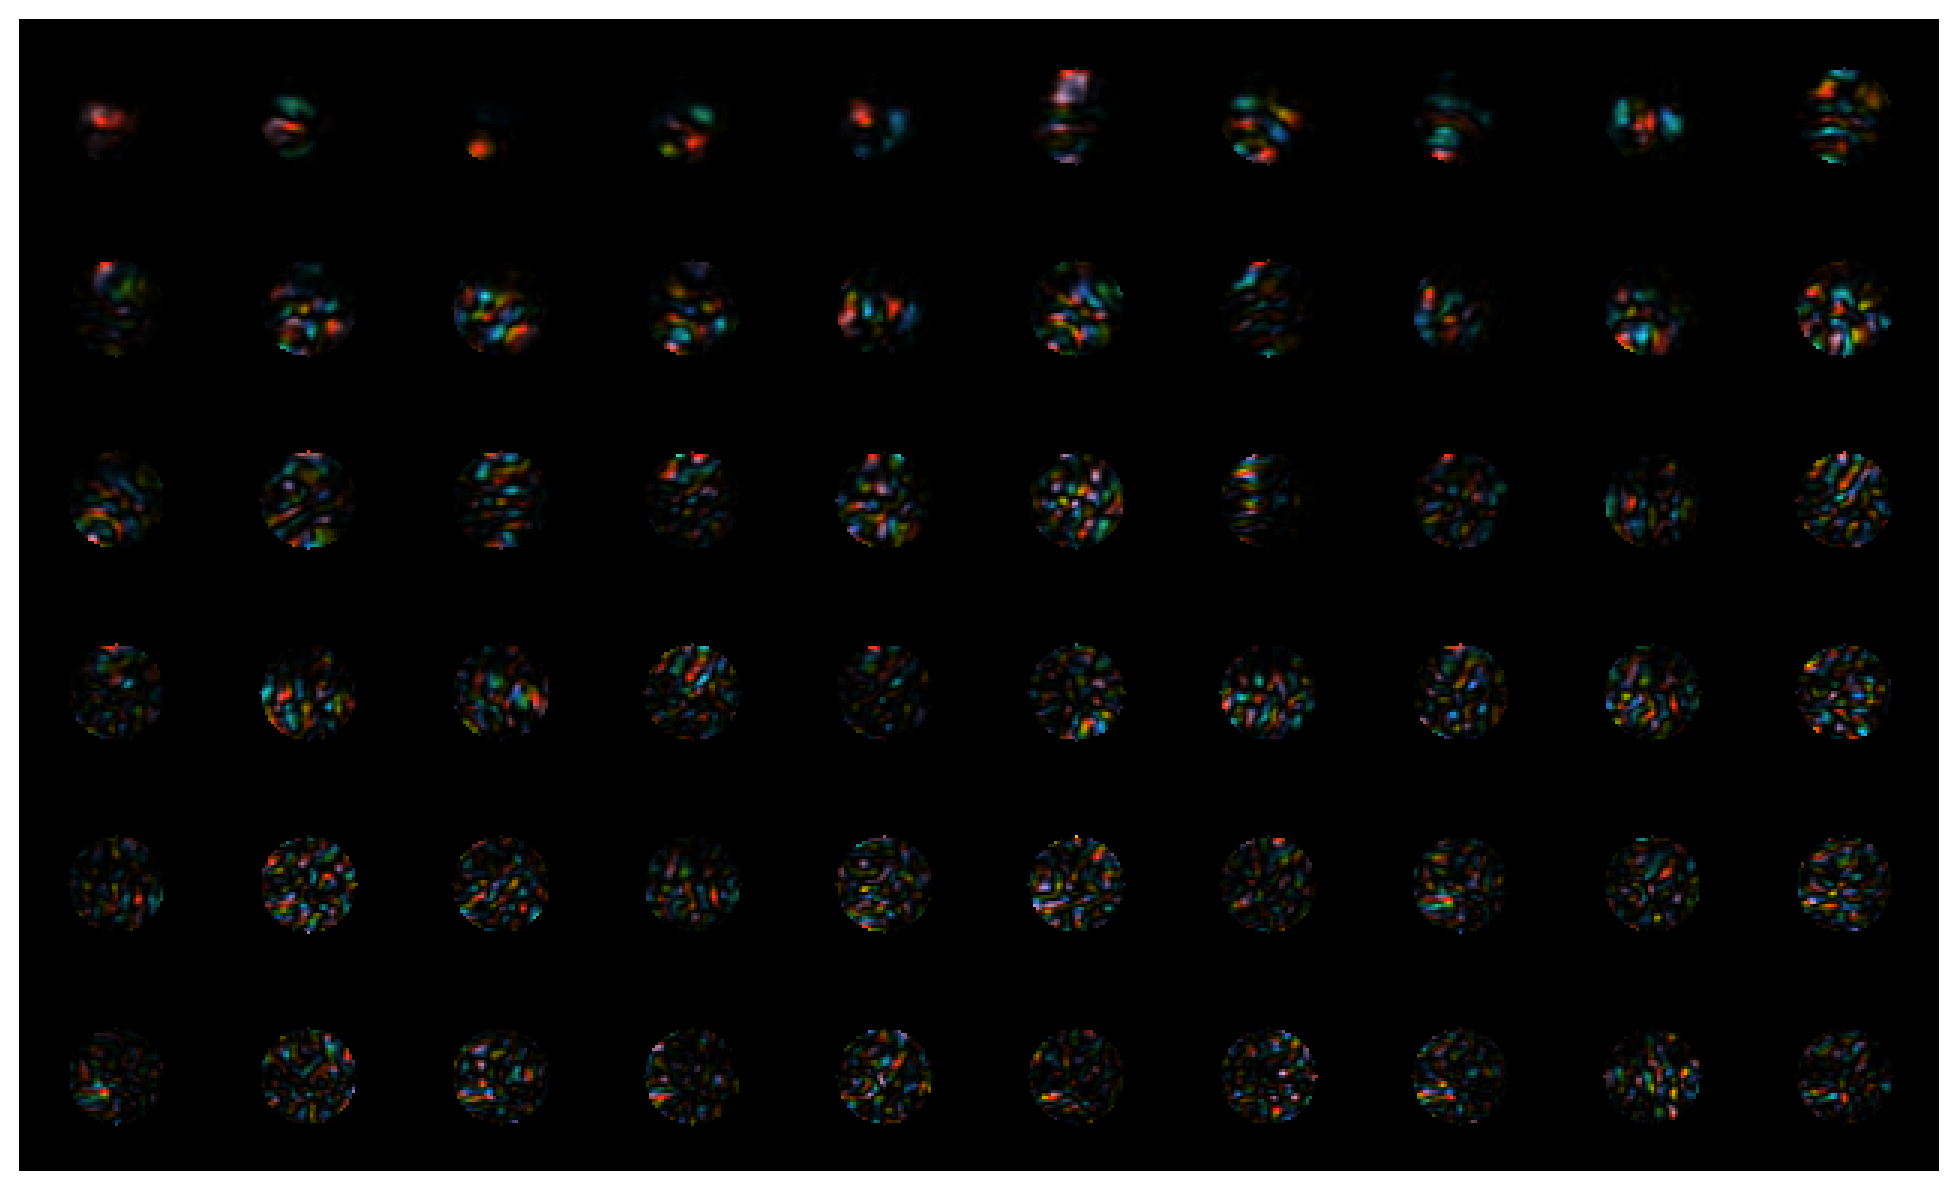

In [124]:
plot=plotBeam(eigenBeams[:60],rows=6,dpi=N*3)
plt.show();plt.close()

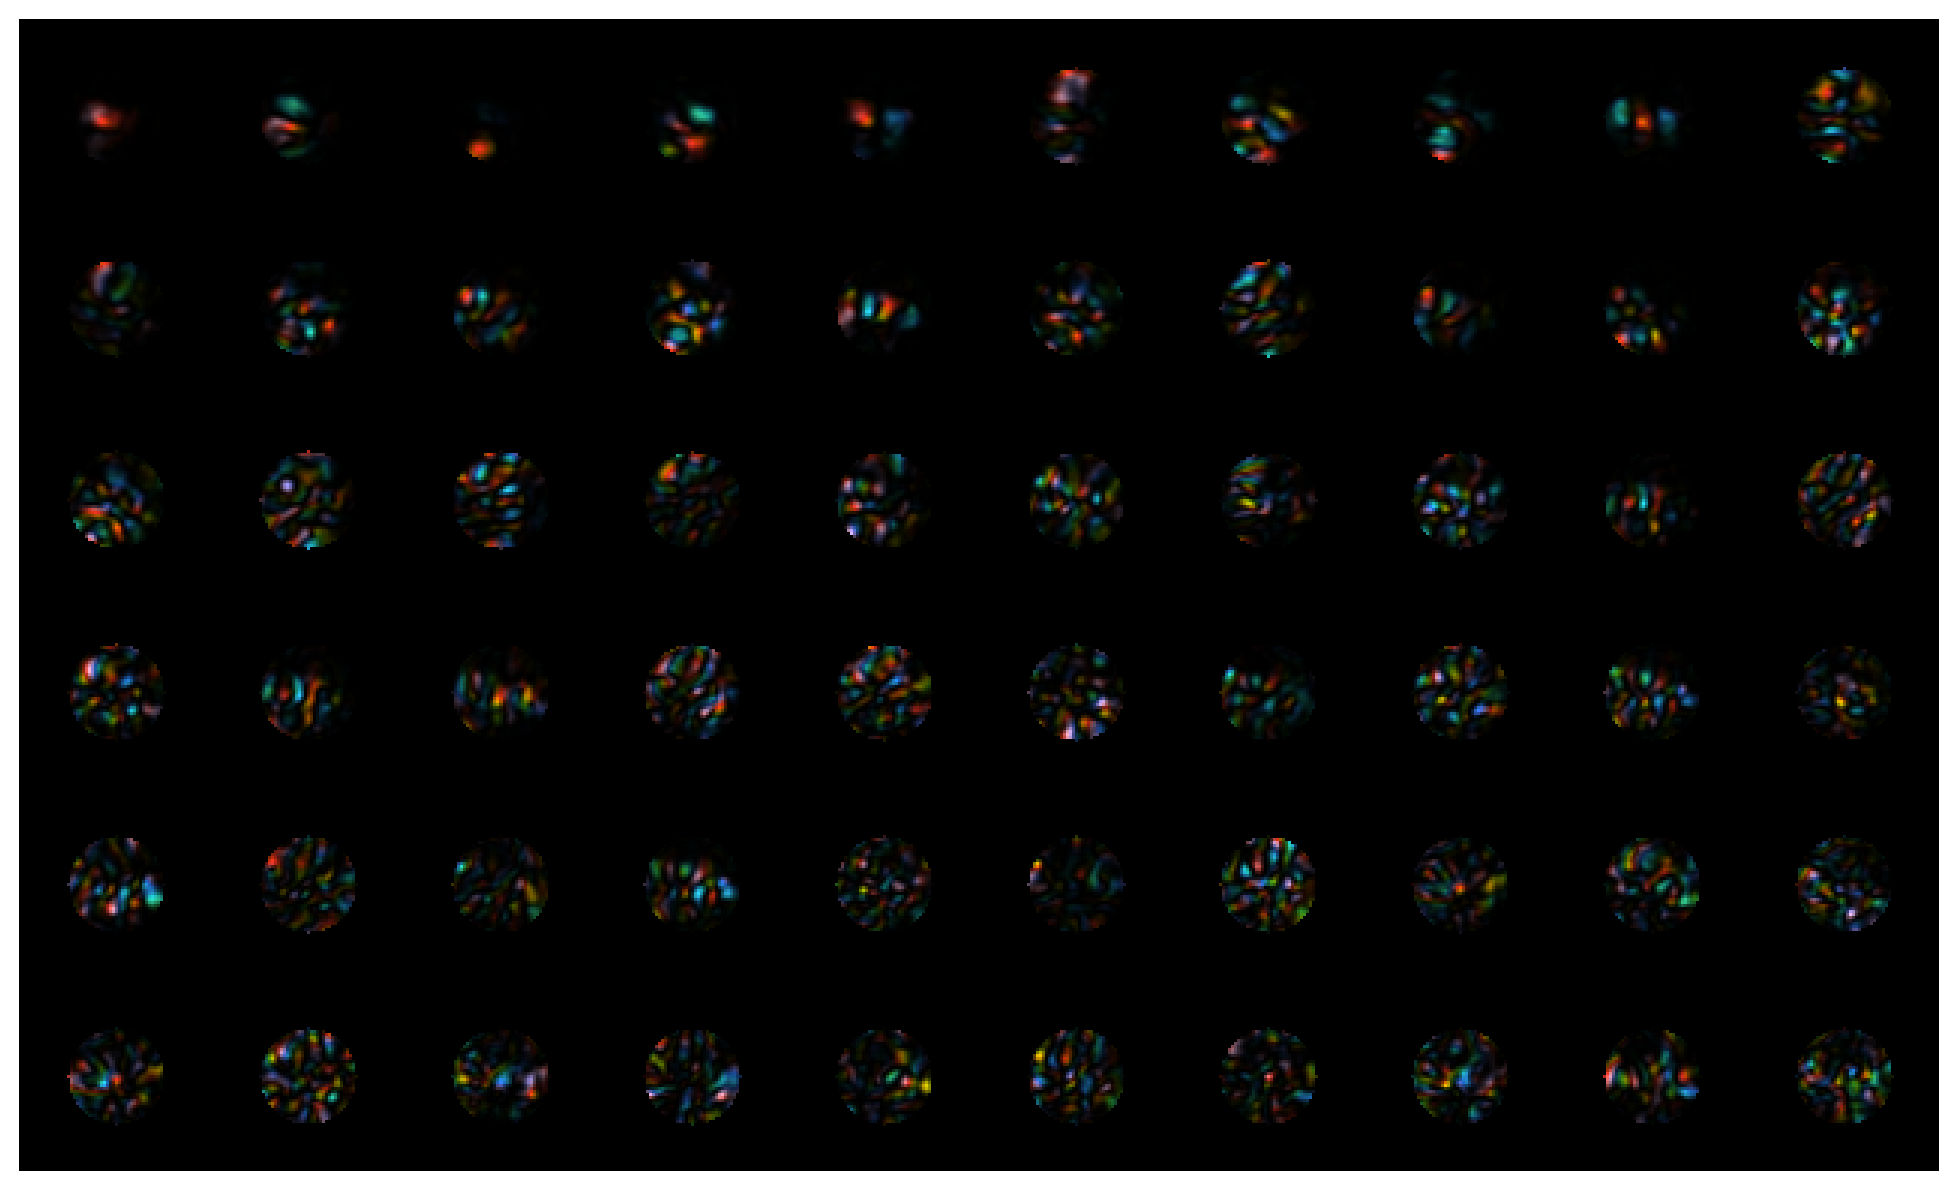

In [125]:
plot=plotBeam([CircAperture(beam,R=lensSize) for beam in eigenBeamPropagated[:60]],rows=6,dpi=N*3)
plt.show();plt.close()

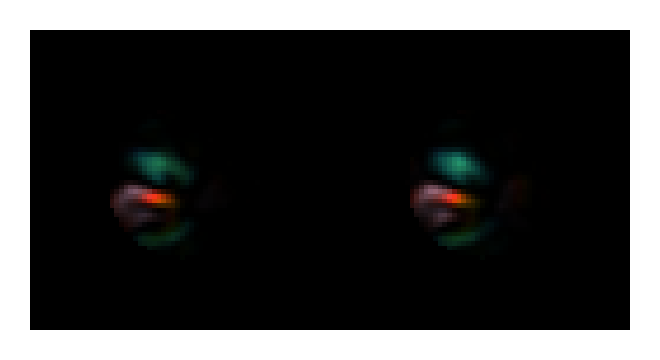

In [126]:
plt.show(plotBeam([eigenBeams[1],CircAperture(eigenBeamPropagated[1],R=lensSize)]))

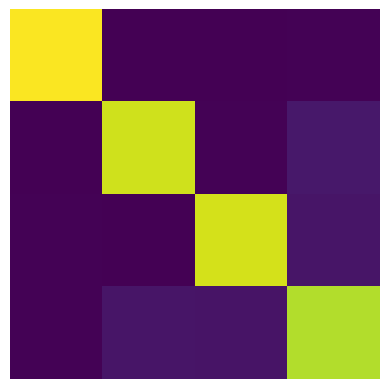

Error rate of 0.0651806655372843 when doing a measurement in the unpropagated Eigenmode basis


In [127]:
modeNumber=4

bestEigenBeams=eigenBeams[:modeNumber]
bestEigenBeamsPropagated=eigenBeamPropagated[:modeNumber]


plt.show(plotCrosstalk(crosstalk(bestEigenBeams,bestEigenBeamsPropagated)))
print(f'Error rate of {beamsError(bestEigenBeams,bestEigenBeamsPropagated)} when doing a measurement in the unpropagated Eigenmode basis')